<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Project_22112025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBoost

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test  Shape: (100, 3)
Train TF-IDF shape: (100, 30711) | Test TF-IDF shape: (100, 30711)

กำลังค้นหา hyperparameters เพื่อดัน Recall...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Params: {'C': np.float64(2.1544346900318834)}

[Validation @ threshold=0.5]
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
F1-score : 1.0
ROC-AUC  : 1.0
PR-AUC   : 0.9999999999999999
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


[Validation @ tuned threshold=0.580] (target recall ≥ 0.95)
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
F1-score : 1.0
ROC-AUC  : 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.

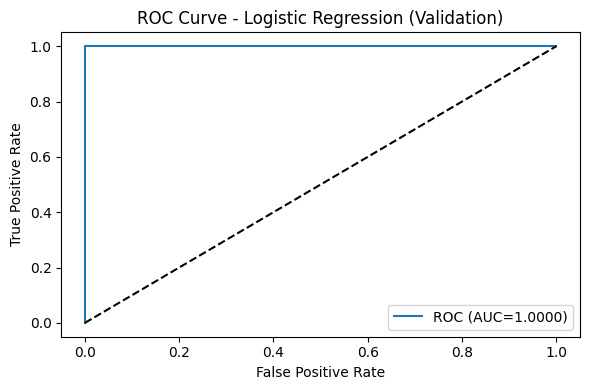

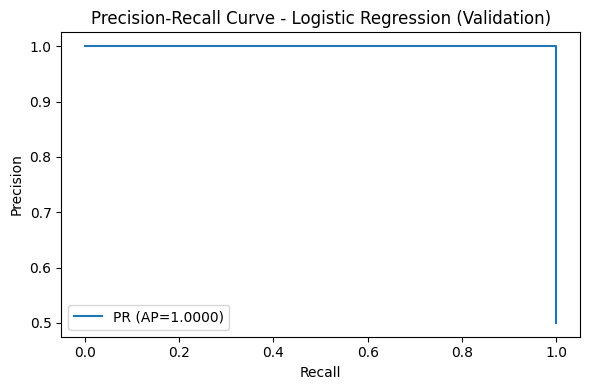


--- ผลลัพธ์ทำนาย (20 แถวแรก) ---
                                    Subject       Label Predicted_Label  \
0                         Pet adoption fair  Legitimate      Legitimate   
1         Win a ticket to parallel universe    Phishing        Phishing   
2                  Science discussion forum  Legitimate        Phishing   
3                         Pet adoption fair  Legitimate      Legitimate   
4                  Public speaking workshop  Legitimate        Phishing   
5           Climate change panel discussion  Legitimate        Phishing   
6    Your DNA test reveals shocking results    Phishing        Phishing   
7         Get access to forbidden knowledge    Phishing        Phishing   
8      Claim your free teleportation device    Phishing        Phishing   
9                  Photography walk details  Legitimate      Legitimate   
10  Become a certified astronaut in 30 days    Phishing      Legitimate   
11         Get free access to hidden vaults    Phishing        Phi

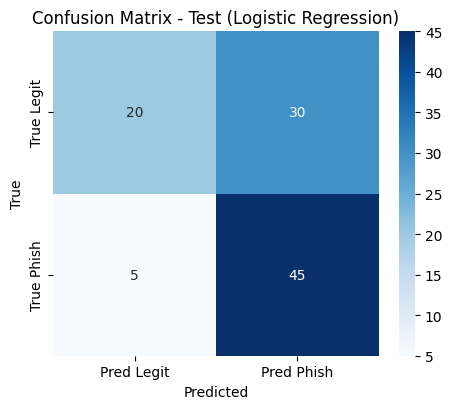

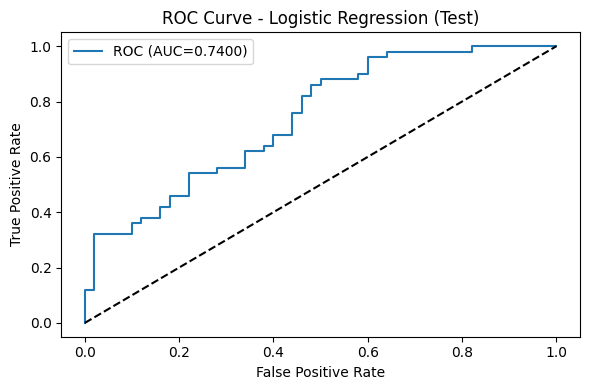

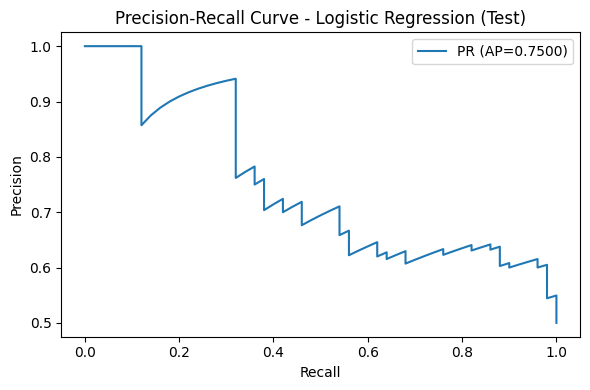


✅ บันทึกไฟล์: test_predictions_lr_recall.csv


In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, confusion_matrix,
    fbeta_score, recall_score, precision_score, f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Prepare Data
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)
X_test_text = test_df['FullText'].fillna('')

test_has_label = False
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    test_has_label = True

# ==============================
# 4) TF-IDF (word + char n-grams)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"Train TF-IDF shape: {X_all.shape} | Test TF-IDF shape: {X_test_all.shape}")

# ==============================
# 5) Split Train/Validation
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Logistic Regression + Hyperparameter Tuning
# ==============================
logreg = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1
)

param_dist = {
    'C': np.logspace(-1, 1, 7)
}

search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังค้นหา hyperparameters เพื่อดัน Recall...")
search.fit(X_tr, y_tr)
best_lr = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning + F1 & ROC-AUC
# ==============================
val_prob = best_lr.predict_proba(X_val)[:, 1]

# Threshold 0.5
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_05))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate', 'Phishing']))

# Threshold tuning เพื่อ recall สูง
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)
best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

val_pred_best = (val_prob >= best_t).astype(int)
print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_best))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate', 'Phishing']))

# Plot ROC - Validation
fpr, tpr, _ = roc_curve(y_val, val_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_val, val_prob):.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# Plot PR - Validation
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test
# ==============================
final_lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    C=search.best_params_['C']
).fit(X_all, y)

test_prob = final_lr.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์ทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ==============================
# ===== Evaluate on TEST + F1 & ROC-AUC & Plots =====
# ==============================
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(submission_df['label_num'], test_pred))
    print("Recall   :", recall_score(submission_df['label_num'], test_pred))
    print("Precision:", precision_score(submission_df['label_num'], test_pred, zero_division=0))
    print("F1-score :", f1_score(submission_df['label_num'], test_pred))
    print("ROC-AUC  :", roc_auc_score(submission_df['label_num'], test_prob))
    print(classification_report(submission_df['label_num'], test_pred, target_names=['Legitimate', 'Phishing']))

    cm = confusion_matrix(submission_df['label_num'], test_pred, labels=[0,1])
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test (Logistic Regression)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()

    # Plot ROC - Test
    fpr_t, tpr_t, _ = roc_curve(submission_df['label_num'], test_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr_t, tpr_t, label=f'ROC (AUC={roc_auc_score(submission_df["label_num"], test_prob):.4f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression (Test)')
    plt.legend(); plt.tight_layout(); plt.show()

    # Plot PR - Test
    prec_t, rec_t, _ = precision_recall_curve(submission_df['label_num'], test_prob)
    plt.figure(figsize=(6,4))
    plt.plot(rec_t, prec_t, label=f'PR (AP={average_precision_score(submission_df["label_num"], test_prob):.4f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Logistic Regression (Test)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (จะแสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

submission_df[out_cols].to_csv('test_predictions_lr_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_lr_recall.csv")

#Naive Bayes
+ SMOTE + Cross-validation + AUC/ROC + Predict Test Set


กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (100, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Cross-Validation Accuracy: 0.9600 ± 0.0374
Cross-Validation AUC: 1.0000 ± 0.0000

[Validation Set]
Accuracy: 1.0000, F1-score: 1.0000, ROC-AUC: 1.0000
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



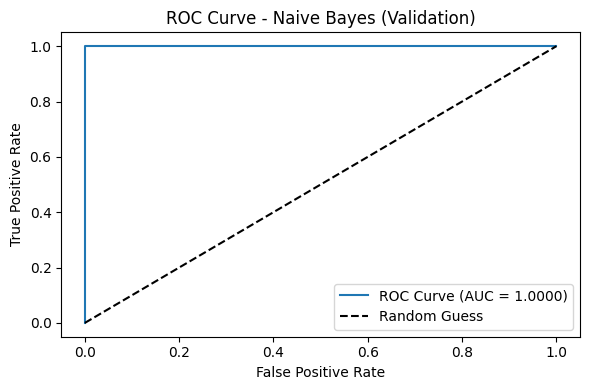


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                    Subject Predicted_Label  \
0                         Pet adoption fair      Legitimate   
1         Win a ticket to parallel universe      Legitimate   
2                  Science discussion forum      Legitimate   
3                         Pet adoption fair      Legitimate   
4                  Public speaking workshop      Legitimate   
5           Climate change panel discussion        Phishing   
6    Your DNA test reveals shocking results        Phishing   
7         Get access to forbidden knowledge      Legitimate   
8      Claim your free teleportation device        Phishing   
9                  Photography walk details      Legitimate   
10  Become a certified astronaut in 30 days      Legitimate   
11         Get free access to hidden vaults        Phishing   
12              Neighborhood safety meeting      Legitimate   
13  Become a certified astronaut in 30 days      Legitimate   
14      A

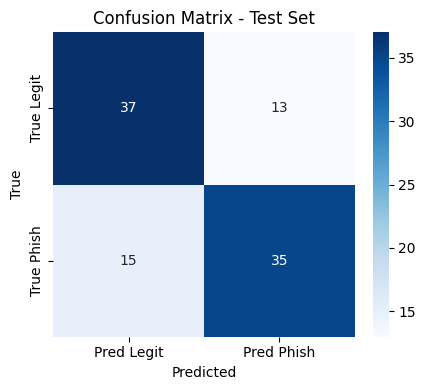

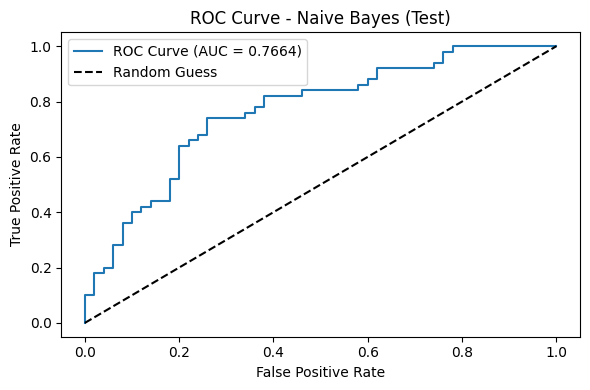


✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv


In [ ]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix, f1_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # ✅ ปิด Warning

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("\nกำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ตรวจสอบคอลัมน์ที่จำเป็น
required_cols = ['Subject', 'Body', 'Label']
missing_train = [c for c in required_cols if c not in train_df.columns]
missing_test_for_eval = [c for c in required_cols if c not in test_df.columns]

if missing_train:
    raise ValueError(f"Train file ขาดคอลัมน์: {missing_train}")
if missing_test_for_eval:
    print(f"⚠️ Test file ไม่มีคอลัมน์สำหรับประเมิน: {missing_test_for_eval}")
    print("โค้ดจะยังสามารถทำนาย test ได้ แต่จะไม่คำนวณ metrics เทียบกับ label จริงของ test set")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

if train_df['label_num'].isna().any():
    bad = train_df[train_df['label_num'].isna()]['Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ถ้า test มี Label จริง ให้แมปด้วย
test_has_label = False
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df[test_df['label_num'].isna()]['Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")
    else:
        test_has_label = True

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 2)
)
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# ==============================
# 5. Train/Validation Split + SMOTE
# ==============================
X_train, X_val, y_train, y_val = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 6. Cross-validation (Accuracy & AUC)
# ==============================
nb_model = MultinomialNB(alpha=0.5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='roc_auc')

print(f"\nCross-Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ==============================
# 7. Train Final Model & Validation Metrics
# ==============================
nb_model.fit(X_train_resampled, y_train_resampled)
y_val_pred = nb_model.predict(X_val)
y_val_prob = nb_model.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_prob)

print("\n[Validation Set]")
print(f"Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}, ROC-AUC: {val_auc:.4f}")
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes (Validation)')
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 8. Predict on Test Set + Evaluation
# ==============================
y_test_prob = nb_model.predict_proba(X_test_vec)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)
test_df['Predicted_Prob_Phishing'] = y_test_prob

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
cols_show = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    cols_show += ['Label']
print(test_df[cols_show].head(20))

# ===== Evaluate on Test (ถ้ามี Label จริง) =====
if test_has_label:
    test_acc = accuracy_score(test_df['label_num'], y_test_pred)
    test_f1 = f1_score(test_df['label_num'], y_test_pred)
    test_auc = roc_auc_score(test_df['label_num'], y_test_prob)

    print("\n[Evaluation on TEST Set]")
    print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}, ROC-AUC: {test_auc:.4f}")
    print(classification_report(
        test_df['label_num'], y_test_pred, target_names=['Legitimate', 'Phishing']
    ))

    cm = confusion_matrix(test_df['label_num'], y_test_pred, labels=[0, 1])
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Plot ROC - Test
    fpr_t, tpr_t, _ = roc_curve(test_df['label_num'], y_test_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_t, tpr_t, label=f'ROC Curve (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Naive Bayes (Test)')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้")

# ==============================
# 9. Save Outputs
# ==============================
out_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols = ['Subject', 'Label', 'Predicted_Label', 'Predicted_Prob_Phishing']
test_df[out_cols].to_csv('test_predictions_nb.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv")

#Random forest

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3) | Test Shape: (100, 3)

กำลังทำ Hyperparameter Tuning (RandomForest) โดยเน้น Recall...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}

[Validation @ threshold=0.5]
Accuracy : 1.0
F1-score : 1.0
Recall   : 1.0
Precision: 1.0
ROC-AUC  : 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


[Validation @ tuned threshold=0.614] (target recall ≥ 0.95)
Accuracy : 1.0
F1-score : 1.0
Recall   : 1.0
Precision: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        

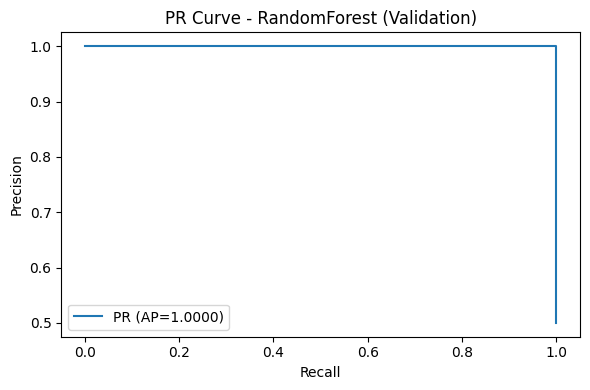

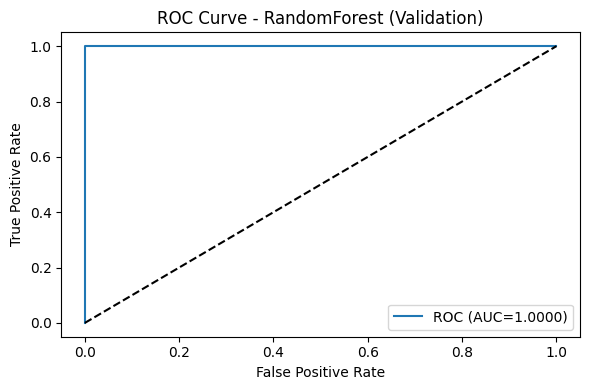


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                    Subject       Label Predicted_Label  \
0                         Pet adoption fair  Legitimate        Phishing   
1         Win a ticket to parallel universe    Phishing        Phishing   
2                  Science discussion forum  Legitimate        Phishing   
3                         Pet adoption fair  Legitimate        Phishing   
4                  Public speaking workshop  Legitimate        Phishing   
5           Climate change panel discussion  Legitimate        Phishing   
6    Your DNA test reveals shocking results    Phishing        Phishing   
7         Get access to forbidden knowledge    Phishing        Phishing   
8      Claim your free teleportation device    Phishing        Phishing   
9                  Photography walk details  Legitimate        Phishing   
10  Become a certified astronaut in 30 days    Phishing        Phishing   
11         Get free access to hidden vaults    Phishin

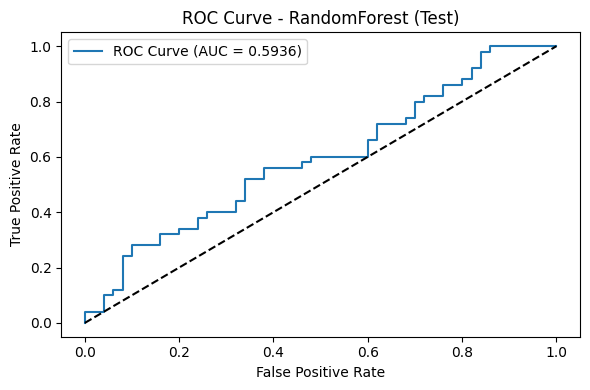


✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_rf_recall.csv


In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    recall_score, precision_score, f1_score, roc_auc_score,
    precision_recall_curve, average_precision_score, roc_curve
)
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape} | Test Shape: {test_df.shape}")

# ==============================
# 3) Prepare Data
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['Label_num'] = train_df['Label'].map(label_mapping)

if train_df['Label_num'].isna().any():
    bad = train_df.loc[train_df['Label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['Label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
y_test_true = test_df['Label'].map(label_mapping) if 'Label' in test_df.columns else None
test_has_label = y_test_true is not None and not y_test_true.isna().any()

# ==============================
# 4) TF-IDF (word + char n-grams)
# ==============================
word_vec = TfidfVectorizer(stop_words='english', lowercase=True, max_features=30000, ngram_range=(1,3), min_df=2, max_df=0.98, sublinear_tf=True)
char_vec = TfidfVectorizer(analyzer='char', lowercase=True, ngram_range=(3,5), min_df=2)

X_word = word_vec.fit_transform(X_text)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

# Feature selection
selector = SelectKBest(chi2, k=min(20000, X_all.shape[1]))
X_sel      = selector.fit_transform(X_all, y)
X_test_sel = selector.transform(X_test_all)

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(X_sel, y, test_size=0.2, random_state=42, stratify=y)

# ==============================
# 6) Random Forest + Hyperparameter Tuning
# ==============================
rf_base = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_split=2,
    min_samples_leaf=1, max_features='sqrt', bootstrap=True,
    class_weight='balanced_subsample', n_jobs=-1, random_state=42
)

param_dist = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt','log2',0.2,0.3]
}

search = RandomizedSearchCV(rf_base, param_distributions=param_dist, n_iter=20, scoring='recall', cv=3, verbose=1, n_jobs=-1, random_state=42)
print("\nกำลังทำ Hyperparameter Tuning (RandomForest) โดยเน้น Recall...")
search.fit(X_tr, y_tr)
best_rf = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning
# ==============================
val_prob = best_rf.predict_proba(X_val)[:,1]
val_pred_05 = (val_prob >= 0.5).astype(int)

print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("F1-score :", f1_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate','Phishing']))

# Tune threshold
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)
best_t = 0.5
best_prec = -1.0
for p,r,t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

mode = f"(target recall ≥ {TARGET_RECALL:.2f})" if best_prec>=0 else "(fallback: maximize recall)"
if best_prec<0: best_t = 0.2
val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("F1-score :", f1_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate','Phishing']))

# Plot PR & ROC
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve - RandomForest (Validation)'); plt.legend(); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_val, val_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_val, val_prob):.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve - RandomForest (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit on Full Train + Predict Test
# ==============================
final_rf = RandomForestClassifier(**search.best_params_, class_weight='balanced_subsample', n_jobs=-1, random_state=42).fit(X_sel, y)
test_prob = final_rf.predict_proba(X_test_sel)[:,1]
test_pred = (test_prob >= best_t).astype(int)

test_df['Predicted_Prob_Phishing'] = test_prob
test_df['Predicted_Label_Num'] = test_pred
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map({0:'Legitimate',1:'Phishing'})

show_cols = ['Subject','Predicted_Label','Predicted_Prob_Phishing']
if test_has_label: show_cols.insert(1,'Label')
print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[show_cols].head(20))

# Evaluate Test Set
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("F1-score :", f1_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred))
    print("ROC-AUC  :", roc_auc_score(y_test_true, test_prob))
    print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test_true, test_pred))
    print("\nClassification Report (Test Set):\n", classification_report(y_test_true, test_pred, target_names=['Legitimate','Phishing']))

    # Plot ROC Test
    fpr_t, tpr_t, _ = roc_curve(y_test_true, test_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr_t, tpr_t, label=f'ROC Curve (AUC = {roc_auc_score(y_test_true, test_prob):.4f})')
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForest (Test)'); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้")

# ==============================
# 9) Save Outputs
# ==============================
out_cols = ['Subject','Predicted_Label','Predicted_Prob_Phishing']
if test_has_label: out_cols.insert(1,'Label')
test_df[out_cols].to_csv('test_predictions_rf_recall.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_rf_recall.csv")

#CatBoost

In [ ]:
pip install catboost

In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    precision_score, recall_score, confusion_matrix, f1_score,
    precision_recall_curve, average_precision_score, fbeta_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ⭐ NEW: ใช้ CatBoost
from catboost import CatBoostClassifier

# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False

if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF (เหมือนเดิม)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)

char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) CatBoost Tuning (แทน Logistic Regression)
# ==============================
# ⭐ NOTE:
# CatBoost รองรับ sparse matrix ได้เลย → ใช้กับ TF-IDF ได้โดยตรง
# ใช้ loss_function='Logloss' เพราะเป็น binary classification

base_cb = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Recall',     # เน้น Recall
    random_seed=42,
    verbose=0,
    thread_count=-1
)

# 🔧 Hyperparameter Search (ปรับแค่บางตัวที่สำคัญ)
param_dist = {
    'depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [500, 800, 1000]
}

print("\nกำลังทำ Hyperparameter Tuning (CatBoost)...")
search = RandomizedSearchCV(
    estimator=base_cb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',  # ยังคงเน้น recall
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_tr, y_tr)

best_cb = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning
# ==============================
val_prob = best_cb.predict_proba(X_val)[:, 1]

print("\n[Validation @ threshold=0.5]")
val_pred_05 = (val_prob >= 0.5).astype(int)
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_05))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))

# -------------- Threshold Tuning --------------
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1

for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

# fallback หากหา threshold ที่ recall ≥ target ไม่เจอ
if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = "(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL})"

val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_best))

# ==============================
# 8) Refit on ALL Train (CatBoost)
# ==============================
final_cb = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0,
    thread_count=-1,
    **search.best_params_
).fit(X_all, y)

test_prob = final_cb.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num'] = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']].head(20))

# ==============================
# 9) Evaluate on TEST (เพิ่ม F1 + ROC-AUC)
# ==============================
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print("F1-score :", f1_score(y_test_true, test_pred))

    # ⭐ ROC-AUC
    roc_auc_test = roc_auc_score(y_test_true, test_prob)
    print("ROC-AUC :", roc_auc_test)

    print("\nClassification Report:")
    print(classification_report(
        y_test_true, test_pred,
        target_names=['Legitimate', 'Phishing']
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ Test ไม่มี Label — จึงคำนวณ F1 / ROC-AUC ไม่ได้")

# ==============================
# 10) Save Predictions
# ==============================
submission_df.to_csv("test_predictions_catboost_recall.csv", index=False)
print("\n✅ Saved: test_predictions_catboost_recall.csv")

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test  Shape: (100, 3)
TF-IDF Train Shape: (100, 30711) | TF-IDF Test Shape: (100, 30711)

กำลังทำ Hyperparameter Tuning (CatBoost)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, precision_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, fbeta_score
)
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'  # ใช้ test.csv

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
# รวม Subject + Body
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

# เข้ารหัส label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False
y_test_true = None
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF: Word + Char (ไม่มี handcrafted features)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,         # เพิ่มความละเอียด
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)       # fit เฉพาะ train
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text) # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# class weights เพื่อช่วยคลาส Phishing (imbalance)
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
class_weights = {0: 1.0, 1: float(neg / max(1, pos))}  # น้ำหนัก ~ neg/pos
print(f"class_weights = {class_weights}")

# ==============================
# 6) CatBoost Model + Early Stopping (เน้น Recall)
# ==============================
# ตั้งค่าเบื้องต้นให้เรียนรู้ลึกพอและหยุดเมื่อไม่ดีขึ้น
cat_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',              # ใช้ AUC เพื่อดูการแยกชั้น
    iterations=1500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    verbose=False,
    class_weights=class_weights,    # ช่วยคลาส phishing
    od_type='Iter',
    od_wait=100                     # early stopping patience
)

# (ทางเลือก) Hyperparameter search แบบเบา ๆ เน้น recall/auc
# หมายเหตุ: CatBoost มีตัว tuner ในตัว แต่ในสคริปต์นี้จะใช้ค่าคงที่ปรับสมดุล
print("\nกำลังฝึกสอนโมเดล CatBoost (early stopping)...")
cat_base.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)
best_cat = cat_base  # ใช้โมเดลที่ดีที่สุดจาก early stopping

# ==============================
# 7) Validation Metrics + Threshold Tuning (ดัน Recall)
# ==============================
val_prob = best_cat.predict_proba(X_val)[:, 1]

# baseline @ 0.5
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate', 'Phishing']))

# ปรับ threshold เพื่อให้ Recall ≥ เป้าหมาย หรือ fallback ด้วย F2-optimal
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

val_pred_best = (val_prob >= best_t).astype(int)
print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate', 'Phishing']))

# ROC
fpr, tpr, _ = roc_curve(y_val, val_prob)
val_auc = roc_auc_score(y_val, val_prob)
plt.figure(figsize=(6.5, 4.8))
plt.plot(fpr, tpr, label=f'ROC (AUC={val_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# PR
plt.figure(figsize=(6.5, 4.8))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test (ใช้ threshold ที่ tune)
# ==============================
final_cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=best_cat.tree_count_,  # ใช้จำนวนต้นไม้ที่ early stopped
    learning_rate=best_cat.get_param('learning_rate'),
    depth=best_cat.get_param('depth'),
    l2_leaf_reg=best_cat.get_param('l2_leaf_reg'),
    random_seed=42,
    verbose=False,
    class_weights=class_weights
).fit(X_all, y)

test_prob = final_cat.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

# แสดงผล 20 แถวแรก
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print(classification_report(y_test_true, test_pred, target_names=['Legitimate', 'Phishing']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred, labels=[0, 1])
    plt.figure(figsize=(4.8, 4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test (CatBoost)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (แสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

final_submission = submission_df[out_cols]
final_submission.to_csv('test_predictions_catboost_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_catboost_recall.csv")

In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, precision_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, fbeta_score, f1_score
)
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X_text = train_df['FullText']
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText']
test_has_label = False
y_test_true = None
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Split Train/Validation
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# class weight
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
class_weights = {0: 1.0, 1: float(neg / pos)}

# ==============================
# 6) CatBoost + Early Stopping
# ==============================
cat_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=1500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    verbose=False,
    class_weights=class_weights,
    od_type='Iter',
    od_wait=100
)

print("\nกำลังฝึกสอนโมเดล CatBoost (early stopping)...")
cat_base.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)
best_cat = cat_base


# ==============================
# 7) Validation Metrics + Threshold Tuning
# ==============================
val_prob = best_cat.predict_proba(X_val)[:, 1]
val_pred_05 = (val_prob >= 0.5).astype(int)

print("\n===== [Validation @ threshold = 0.5] =====")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05))
print("F1 Score :", f1_score(y_val, val_pred_05))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05))


# --- Best threshold tuning ---
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = "(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL})"

val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n===== [Validation @ tuned threshold = {best_t:.3f}] {mode} =====")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best))
print("F1 Score :", f1_score(y_val, val_pred_best))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print(classification_report(y_val, val_pred_best))


# ==============================
# 8) Refit All + Predict Test
# ==============================
final_cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=best_cat.tree_count_,
    learning_rate=best_cat.get_param('learning_rate'),
    depth=best_cat.get_param('depth'),
    l2_leaf_reg=best_cat.get_param('l2_leaf_reg'),
    random_seed=42,
    verbose=False,
    class_weights=class_weights
).fit(X_all, y)

test_prob = final_cat.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)


# ==============================
# 9) Show Test Predictions
# ==============================
submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print(submission_df[show_cols].head(20))


# ==============================
# 10) TEST Metrics (ถ้ามี Label จริง)
# ==============================
if test_has_label:
    print("\n===== [Evaluation on TEST Set] =====")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred))
    print("F1 Score :", f1_score(y_test_true, test_pred))
    print("ROC-AUC  :", roc_auc_score(y_test_true, test_prob))
    print(classification_report(y_test_true, test_pred))


# ==============================
# 11) Save CSV
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

submission_df[out_cols].to_csv('test_predictions_catboost_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_catboost_recall.csv")

#Logistic

In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, recall_score,
    precision_score, confusion_matrix, fbeta_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False

if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)

char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Logistic Regression Tuning
# ==============================
base_lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

param_dist = {
    'C': np.logspace(-1, 1, 7)
}

print("\nกำลังทำ Hyperparameter Tuning...")
search = RandomizedSearchCV(
    estimator=base_lr,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search.fit(X_tr, y_tr)

best_lr = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning
# ==============================
val_prob = best_lr.predict_proba(X_val)[:, 1]

print("\n[Validation @ threshold=0.5]")
val_pred_05 = (val_prob >= 0.5).astype(int)
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_05))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))

# ---- threshold tuning ----
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1

for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = "(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL})"

val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, val_pred_best))

# ==============================
# 8) Refit on All Train + Predict Test
# ==============================
final_lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
    C=search.best_params_['C']
).fit(X_all, y)

test_prob = final_lr.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num'] = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']].head(20))

# ==============================
# 9) Evaluate on TEST (เพิ่ม F1-score + ROC-AUC)
# ==============================
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print("F1-score :", f1_score(y_test_true, test_pred))

    # ⭐ ROC-AUC (เพิ่ม)
    roc_auc_test = roc_auc_score(y_test_true, test_prob)
    print("ROC-AUC :", roc_auc_test)

    print("\nClassification Report:")
    print(classification_report(y_test_true, test_pred,
                                target_names=['Legitimate', 'Phishing']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Test ไม่มี Label — จึงคำนวณ F1 / ROC-AUC ไม่ได้")

# ==============================
# 10) Save Predictions
# ==============================
submission_df.to_csv("test_predictions_logistic_recall.csv", index=False)
print("\n✅ Saved: test_predictions_logistic_recall.csv")

# Soft Voting Ensemble (ผสมความน่าจะเป็นจากโมเดลหลายตัว)
ใช้ TF‑IDF (word 1–3 + char 3–5 n‑grams)
โมเดลฐาน: Logistic Regression (balanced) + CatBoost (class_weights + early stopping) + XGBoost (scale_pos_weight)
คำนวณ น้ำหนักของแต่ละโมเดลจาก PR‑AUC บน Validation แล้ว ปรับ threshold ให้ดัน Recall ≥ เป้า
ประเมินบน test set จริง ถ้ามีคอลัมน์ Label

In [ ]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, precision_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, fbeta_score, roc_curve
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'  # ใช้ test.csv

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
# รวม Subject + Body
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

# เข้ารหัส label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False
y_test_true = None
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF: Word + Char (ไม่มี handcrafted features)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,         # เพิ่มความละเอียด
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)       # fit เฉพาะ train (หลีกเลี่ยง leakage)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text) # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Base Models (LR + CatBoost + XGB)
# ==============================
# 6.1 Logistic Regression (balanced)
lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
    C=1.0
)
lr.fit(X_tr, y_tr)

# 6.2 CatBoost (class_weights + early stopping)
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
class_weights = {0: 1.0, 1: float(neg / max(1, pos))}

cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=1500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    verbose=False,
    class_weights=class_weights,
    od_type='Iter',
    od_wait=100
)
cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)

# 6.3 XGBoost (scale_pos_weight)
scale_pos_weight = neg / max(1, pos)
xgb = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    n_estimators=800,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1.5,
    scale_pos_weight=scale_pos_weight
)
xgb.fit(X_tr, y_tr)

# ==============================
# 7) Validation: individual & ensemble (soft voting)
# ==============================
val_prob_lr  = lr.predict_proba(X_val)[:, 1]
val_prob_cat = cat.predict_proba(X_val)[:, 1]
val_prob_xgb = xgb.predict_proba(X_val)[:, 1]

# น้ำหนักจาก PR-AUC (ยิ่งดี ยิ่งหนัก)
w_lr  = average_precision_score(y_val, val_prob_lr)
w_cat = average_precision_score(y_val, val_prob_cat)
w_xgb = average_precision_score(y_val, val_prob_xgb)

weights = np.array([w_lr, w_cat, w_xgb], dtype=float)
weights = weights / (weights.sum() + 1e-12)

val_prob_ens = weights[0]*val_prob_lr + weights[1]*val_prob_cat + weights[2]*val_prob_xgb

print("\n[Validation PR-AUC Weights]")
print(f"LR:  {w_lr:.4f} | CatBoost: {w_cat:.4f} | XGB: {w_xgb:.4f} -> norm weights: {weights.round(4)}")

# baseline @ 0.5
def report_metrics(name, y_true, prob, thr=0.5):
    pred = (prob >= thr).astype(int)
    print(f"\n[{name} @ threshold={thr:.2f}]")
    print("Accuracy :", accuracy_score(y_true, pred))
    print("Recall   :", recall_score(y_true, pred))
    print("Precision:", precision_score(y_true, pred, zero_division=0))
    print(classification_report(y_true, pred, target_names=['Legitimate','Phishing']))
    print("ROC-AUC  :", roc_auc_score(y_true, prob))
    print("PR-AUC   :", average_precision_score(y_true, prob))

report_metrics("Validation - LR",  y_val, val_prob_lr,  0.5)
report_metrics("Validation - Cat", y_val, val_prob_cat, 0.5)
report_metrics("Validation - XGB", y_val, val_prob_xgb, 0.5)
report_metrics("Validation - Ensemble", y_val, val_prob_ens, 0.5)

# ปรับ threshold เพื่อดัน Recall ≥ เป้าหมาย หรือ fallback ด้วย F2
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob_ens)

best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob_ens >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

report_metrics(f"Validation - Ensemble {mode}", y_val, val_prob_ens, best_t)

# วาด ROC/PR ของ Ensemble
fpr, tpr, _ = roc_curve(y_val, val_prob_ens)
plt.figure(figsize=(6.5, 4.8))
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={roc_auc_score(y_val, val_prob_ens):.3f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve - Ensemble (Validation)'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5, 4.8))
plt.plot(rec, prec, label=f'Ensemble PR (AP={average_precision_score(y_val, val_prob_ens):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble (Validation)'); plt.legend(); plt.tight_layout(); plt.show()
# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test (ใช้ weights/threshold ที่ tune)
# ==============================
# Refit ทุกโมเดลบน train ทั้งหมด
lr_full = LogisticRegression(
    solver='saga', penalty='l2', class_weight='balanced',
    max_iter=5000, n_jobs=-1, random_state=42, C=1.0
).fit(X_all, y)

cat_full = CatBoostClassifier(
    loss_function='Logloss', eval_metric='AUC',
    iterations=cat.tree_count_, learning_rate=cat.get_param('learning_rate'),
    depth=cat.get_param('depth'), l2_leaf_reg=cat.get_param('l2_leaf_reg'),
    random_seed=42, verbose=False, class_weights=class_weights
).fit(X_all, y)

xgb_full = XGBClassifier(
    objective='binary:logistic', tree_method='hist', n_jobs=-1, random_state=42,
    eval_metric='logloss', n_estimators=xgb.n_estimators, max_depth=xgb.max_depth,
    learning_rate=xgb.learning_rate, subsample=xgb.subsample,
    colsample_bytree=xgb.colsample_bytree, gamma=xgb.gamma,
    reg_alpha=xgb.reg_alpha, reg_lambda=xgb.reg_lambda,
    scale_pos_weight=scale_pos_weight
).fit(X_all, y)

# Test probabilities
test_prob_lr = lr_full.predict_proba(X_test_all)[:, 1]
test_prob_cat = cat_full.predict_proba(X_test_all)[:, 1]
test_prob_xgb = xgb_full.predict_proba(X_test_all)[:, 1]

test_prob_ens = weights[0]*test_prob_lr + weights[1]*test_prob_cat + weights[2]*test_prob_xgb
test_pred_ens = (test_prob_ens >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Pred_Prob_Phishing_LR'] = test_prob_lr
submission_df['Pred_Prob_Phishing_Cat'] = test_prob_cat
submission_df['Pred_Prob_Phishing_XGB'] = test_prob_xgb
submission_df['Pred_Prob_Phishing_Ensemble'] = test_prob_ens
submission_df['Predicted_Label_Num'] = test_pred_ens
rev_map = {0:'Legitimate', 1:'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

# แสดงผล 20 แถวแรก
show_cols = ['Subject', 'Predicted_Label', 'Pred_Prob_Phishing_Ensemble']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set - Ensemble]")
    print(f"Threshold used: {best_t:.3f} | Weights: LR={weights[0]:.3f}, Cat={weights[1]:.3f}, XGB={weights[2]:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred_ens))
    print("Recall   :", recall_score(y_test_true, test_pred_ens))
    print("Precision:", precision_score(y_test_true, test_pred_ens, zero_division=0))
    print(classification_report(y_test_true, test_pred_ens, target_names=['Legitimate','Phishing']))

    # 8.1 Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred_ens, labels=[0,1])
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit','Pred Phish'],
                yticklabels=['True Legit','True Phish'])
    plt.title('Confusion Matrix - Test (Ensemble)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()

    # 8.2 เพิ่ม ROC Curve บน Test Set
    fpr_test, tpr_test, _ = roc_curve(y_test_true, test_prob_ens)
    test_auc = roc_auc_score(y_test_true, test_prob_ens)

    plt.figure(figsize=(6.5, 4.8))
    plt.plot(fpr_test, tpr_test, label=f'Ensemble ROC (AUC={test_auc:.3f})')
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curve - Ensemble (Test Set)'); plt.legend(); plt.tight_layout(); plt.show()

else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (แสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Pred_Prob_Phishing_Ensemble']
if test_has_label:
    out_cols.insert(1, 'Label')

submission_df[out_cols].to_csv('test_predictions_ensemble.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_ensemble.csv")